In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.2.1+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import os
import pathlib

from PIL import Image
import zipfile
import requests
import shutil

from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [4]:
# Setup path to data folder
data_path = pathlib.Path("data/")
image_path = data_path / "PlantVillage"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download PlantVillage data
    with open(data_path / "PlantVillage.zip", "wb") as f:
        request = requests.get("https://github.com/monisakhtar/PotatoDiseaseClassification/raw/main/data/PlantVillage.zip")
        print("Downloading Plant Village data...")
        f.write(request.content)
        f.close()

    # Unzip PlantVillage data
    with zipfile.ZipFile(data_path / "PlantVillage.zip", "r") as zip_ref:
        print("Unzipping Plant Village data...")
        zip_ref.extractall(image_path)

data/PlantVillage directory exists.


In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/PlantVillage'.
There are 3 directories and 0 images in 'data/PlantVillage/train'.
There are 0 directories and 800 images in 'data/PlantVillage/train/Potato___Early_blight'.
There are 0 directories and 800 images in 'data/PlantVillage/train/Potato___Late_blight'.
There are 0 directories and 121 images in 'data/PlantVillage/train/Potato___healthy'.
There are 3 directories and 0 images in 'data/PlantVillage/test'.
There are 0 directories and 200 images in 'data/PlantVillage/test/Potato___Early_blight'.
There are 0 directories and 200 images in 'data/PlantVillage/test/Potato___Late_blight'.
There are 0 directories and 31 images in 'data/PlantVillage/test/Potato___healthy'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/PlantVillage/train'), PosixPath('data/PlantVillage/test'))

Random image path: data/PlantVillage/train/Potato___Early_blight/bb07a1b7-b9ad-4016-a013-9ff0e4636d4a___RS_Early.B 7156.JPG
Image class: Potato___Early_blight
Image height: 256
Image width: 256


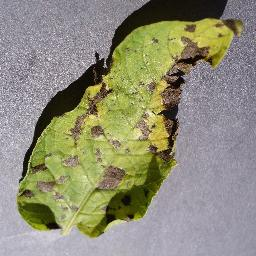

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.JPG"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

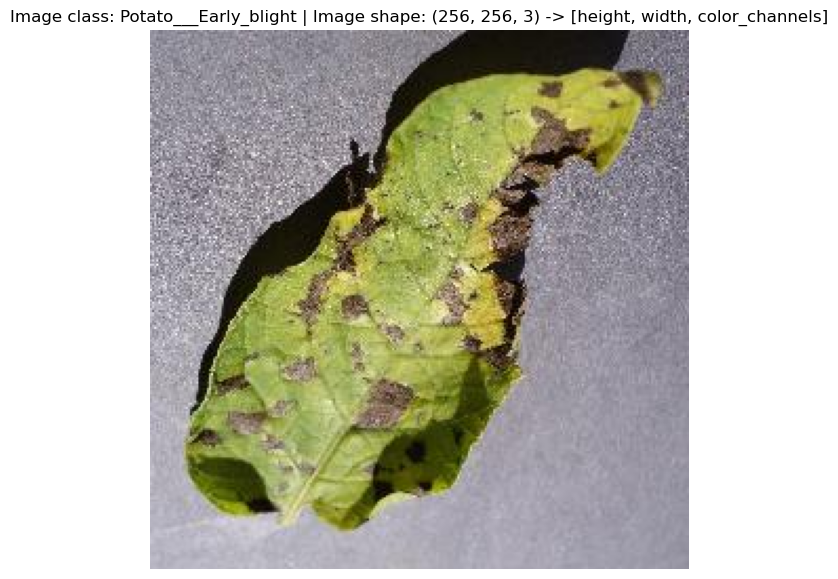

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [10]:
from torchvision import datasets, transforms

IMAGE_SIZE = 256

# Define transformations for image preprocessing
data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# Load the dataset using ImageFolder
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1721
    Root location: data/PlantVillage/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 431
    Root location: data/PlantVillage/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [11]:
# Get class names as a list
class_names = train_data.classes
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

In [13]:
# Check the lengths
len(train_data), len(test_data)

(1721, 431)

In [14]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.4824, 0.6314, 0.5804,  ..., 0.6824, 0.6706, 0.6627],
         [0.5137, 0.5804, 0.5569,  ..., 0.7216, 0.7059, 0.6902],
         [0.5882, 0.5255, 0.5176,  ..., 0.7020, 0.6863, 0.6745],
         ...,
         [0.5843, 0.4588, 0.5098,  ..., 0.6275, 0.6314, 0.6314],
         [0.4235, 0.4118, 0.4941,  ..., 0.6353, 0.6392, 0.6431],
         [0.5765, 0.3647, 0.5020,  ..., 0.6627, 0.6745, 0.6784]],

        [[0.4706, 0.6196, 0.5686,  ..., 0.6706, 0.6588, 0.6510],
         [0.5020, 0.5686, 0.5451,  ..., 0.7098, 0.6941, 0.6784],
         [0.5765, 0.5137, 0.5059,  ..., 0.6902, 0.6745, 0.6627],
         ...,
         [0.5686, 0.4431, 0.4941,  ..., 0.6196, 0.6235, 0.6235],
         [0.4078, 0.3961, 0.4784,  ..., 0.6275, 0.6314, 0.6353],
         [0.5608, 0.3490, 0.4863,  ..., 0.6549, 0.6667, 0.6706]],

        [[0.4980, 0.6471, 0.5961,  ..., 0.6980, 0.6863, 0.6784],
         [0.5294, 0.5961, 0.5725,  ..., 0.7373, 0.7216, 0.7059],
         [0.6039, 0.5412, 0.5333,  ..., 0.71

Original shape: torch.Size([3, 256, 256]) -> [color_channels, height, width]
Image permute shape: torch.Size([256, 256, 3]) -> [height, width, color_channels]


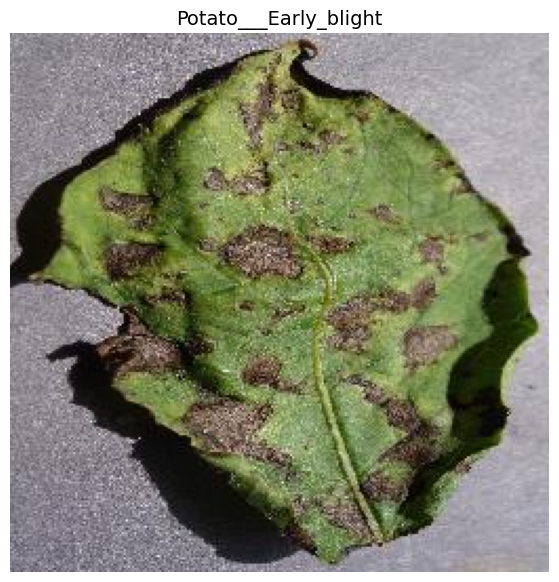

In [15]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [16]:
# Create a DataLoader for batching and shuffling
BATCH_SIZE = 32
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x742e72b1fa30>,
 <torch.utils.data.dataloader.DataLoader at 0x742e72b1df90>)

In [17]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 256, 256]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [18]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(20, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

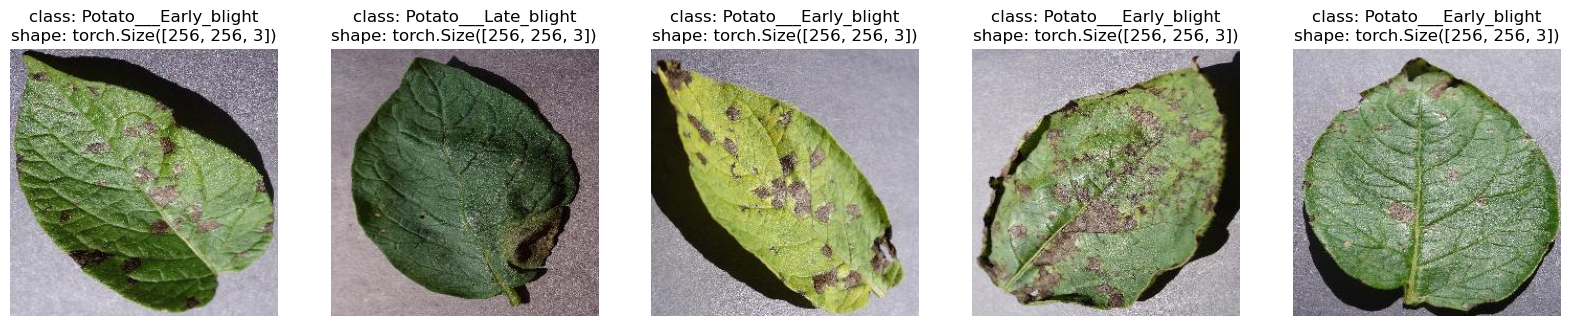

In [19]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

## Data Augmentation

In [20]:
from torchvision import datasets, transforms

IMAGE_SIZE = 256

# Define transformations for image preprocessing
data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])



train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Load the dataset using ImageFolder
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)
# Load the dataset using ImageFolder
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_transform_trivial_augment, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)



print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1721
    Root location: data/PlantVillage/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 431
    Root location: data/PlantVillage/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [21]:
# Create a DataLoader for batching and shuffling
BATCH_SIZE = 32
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x742e72b1f730>,
 <torch.utils.data.dataloader.DataLoader at 0x742e72b1dea0>)

In [22]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 256, 256]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## Model Building

In [23]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
class CNN_model(nn.Module):
  def __init__(self, input_shape:int, hidden_units: int, output_shape : int):
    super().__init__()
    self.cnn_layers = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride =2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units *128 * 128,
                  out_features=output_shape)
    )
  def forward(self, x: torch.Tensor):
    x = self.cnn_layers(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

cnn_model = CNN_model(input_shape=3,
                      hidden_units= 10,
                      output_shape=3).to(device)
cnn_model

CNN_model(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=163840, out_features=3, bias=True)
  )
)

In [24]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(cnn_model, input_size=[32, 3, 256, 256]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
CNN_model                                [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 10, 256, 256]        280
│    └─ReLU: 2-2                         [32, 10, 256, 256]        --
│    └─MaxPool2d: 2-3                    [32, 10, 128, 128]        --
├─Sequential: 1-2                        [32, 3]                   --
│    └─Flatten: 2-4                      [32, 163840]              --
│    └─Linear: 2-5                       [32, 3]                   491,523
Total params: 491,803
Trainable params: 491,803
Non-trainable params: 0
Total mult-adds (M): 602.93
Input size (MB): 25.17
Forward/backward pass size (MB): 167.77
Params size (MB): 1.97
Estimated Total Size (MB): 194.91

In [25]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=cnn_model.parameters(), lr=0.1)

helper_functions.py already exists, skipping download


In [26]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*64*64,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_TinyVGG = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=3).to(device)
model_TinyVGG

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=40960, out_features=3, bias=True)
  )
)

In [27]:
summary(model_TinyVGG, input_size=[32, 3, 256, 256]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 10, 256, 256]        280
│    └─ReLU: 2-2                         [32, 10, 256, 256]        --
│    └─Conv2d: 2-3                       [32, 10, 256, 256]        910
│    └─ReLU: 2-4                         [32, 10, 256, 256]        --
│    └─MaxPool2d: 2-5                    [32, 10, 128, 128]        --
├─Sequential: 1-2                        [32, 10, 64, 64]          --
│    └─Conv2d: 2-6                       [32, 10, 128, 128]        910
│    └─ReLU: 2-7                         [32, 10, 128, 128]        --
│    └─Conv2d: 2-8                       [32, 10, 128, 128]        910
│    └─ReLU: 2-9                         [32, 10, 128, 128]        --
│    └─MaxPool2d: 2-10                   [32, 10, 64, 64]          --
├─Sequentia

In [28]:
class BaseModel_0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 64 * 64,
                      out_features=output_shape),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_0 = BaseModel_0(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=3).to(device)
model_0

BaseModel_0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=40960, out_features=3, bias=True)
  )
)

In [29]:
summary(model_0, input_size=[32, 3, 256, 256]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
BaseModel_0                              [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 10, 256, 256]        280
│    └─ReLU: 2-2                         [32, 10, 256, 256]        --
│    └─Conv2d: 2-3                       [32, 10, 256, 256]        910
│    └─ReLU: 2-4                         [32, 10, 256, 256]        --
│    └─MaxPool2d: 2-5                    [32, 10, 128, 128]        --
├─Sequential: 1-2                        [32, 10, 64, 64]          --
│    └─Conv2d: 2-6                       [32, 10, 128, 128]        910
│    └─ReLU: 2-7                         [32, 10, 128, 128]        --
│    └─Conv2d: 2-8                       [32, 10, 128, 128]        910
│    └─ReLU: 2-9                         [32, 10, 128, 128]        --
│    └─MaxPool2d: 2-10                   [32, 10, 64, 64]          --
├─Sequentia

In [30]:
class BaseModel_1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_6 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # self.classifier = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(64 * (input_shape // (2 ** 5)) * (input_shape // (2 ** 5)), 64),  # Adjusted input size
        #     nn.ReLU(),
        #     nn.Linear(64, out_features=output_shape),
        # )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*2*2,64),
            nn.Linear(64,
                      out_features=output_shape),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.conv_block_3(x)
        # print(x.shape)
        x = self.conv_block_4(x)
        # print(x.shape)
        x = self.conv_block_5(x)
        # print(x.shape)
        x = self.conv_block_6(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_1 = BaseModel_1(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=32,
                  output_shape=3).to(device)
model_1

BaseModel_1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_6): Seque

In [31]:
summary(model_1, input_size=[32, 3, 256, 256]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
BaseModel_1                              [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 127, 127]        --
│    └─Conv2d: 2-1                       [32, 32, 254, 254]        896
│    └─ReLU: 2-2                         [32, 32, 254, 254]        --
│    └─MaxPool2d: 2-3                    [32, 32, 127, 127]        --
├─Sequential: 1-2                        [32, 64, 62, 62]          --
│    └─Conv2d: 2-4                       [32, 64, 125, 125]        18,496
│    └─ReLU: 2-5                         [32, 64, 125, 125]        --
│    └─MaxPool2d: 2-6                    [32, 64, 62, 62]          --
├─Sequential: 1-3                        [32, 64, 30, 30]          --
│    └─Conv2d: 2-7                       [32, 64, 60, 60]          36,928
│    └─ReLU: 2-8                         [32, 64, 60, 60]          --
│    └─MaxPool2d: 2-9                    [32, 64, 30, 30]          --
├─Sequ

In [32]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [33]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [34]:
# from tqdm.notebook import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          print_every: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [51]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

# Recreate an instance of TinyVGG
cnn_model = CNN_model(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=3).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn_model.parameters())

cnn_model_results = train(model=cnn_model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 1.4031 | train_acc: 0.6733 | test_loss: 0.3359 | test_acc: 0.9083
Epoch: 5 | train_loss: 0.3745 | train_acc: 0.8629 | test_loss: 0.1911 | test_acc: 0.9243
Epoch: 10 | train_loss: 0.2859 | train_acc: 0.8961 | test_loss: 0.1543 | test_acc: 0.9567
Epoch: 15 | train_loss: 0.2476 | train_acc: 0.9103 | test_loss: 0.2418 | test_acc: 0.8753
Epoch: 20 | train_loss: 0.2461 | train_acc: 0.9066 | test_loss: 0.1857 | test_acc: 0.9287
Epoch: 25 | train_loss: 0.2108 | train_acc: 0.9321 | test_loss: 0.1387 | test_acc: 0.9519
Epoch: 30 | train_loss: 0.2046 | train_acc: 0.9220 | test_loss: 0.1279 | test_acc: 0.9497
Epoch: 35 | train_loss: 0.2105 | train_acc: 0.9159 | test_loss: 0.1023 | test_acc: 0.9662
Epoch: 40 | train_loss: 0.1626 | train_acc: 0.9383 | test_loss: 0.1473 | test_acc: 0.9528
Epoch: 45 | train_loss: 0.1582 | train_acc: 0.9404 | test_loss: 0.0714 | test_acc: 0.9777
Epoch: 50 | train_loss: 0.1781 | train_acc: 0.9300 | test_loss: 0.1898 | test_acc: 0.9260
Epoch: 55 | 

In [52]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

# Recreate an instance of TinyVGG
model_TinyVGG = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=3).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_TinyVGG.parameters())

model_TinyVGG_results = train(model=model_TinyVGG,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 0.9021 | train_acc: 0.5326 | test_loss: 0.7265 | test_acc: 0.8438
Epoch: 5 | train_loss: 0.4745 | train_acc: 0.8101 | test_loss: 0.2623 | test_acc: 0.8908
Epoch: 10 | train_loss: 0.3729 | train_acc: 0.8483 | test_loss: 0.2876 | test_acc: 0.9101
Epoch: 15 | train_loss: 0.3951 | train_acc: 0.8424 | test_loss: 0.4475 | test_acc: 0.8326
Epoch: 20 | train_loss: 0.2959 | train_acc: 0.8764 | test_loss: 0.1126 | test_acc: 0.9478
Epoch: 25 | train_loss: 0.2620 | train_acc: 0.9029 | test_loss: 0.0981 | test_acc: 0.9621
Epoch: 30 | train_loss: 0.2055 | train_acc: 0.9242 | test_loss: 0.0822 | test_acc: 0.9621
Epoch: 35 | train_loss: 0.2197 | train_acc: 0.9172 | test_loss: 0.0970 | test_acc: 0.9688
Epoch: 40 | train_loss: 0.1856 | train_acc: 0.9224 | test_loss: 0.1246 | test_acc: 0.9478
Epoch: 45 | train_loss: 0.1916 | train_acc: 0.9335 | test_loss: 0.1074 | test_acc: 0.9612
Epoch: 50 | train_loss: 0.1702 | train_acc: 0.9375 | test_loss: 0.0835 | test_acc: 0.9640
Epoch: 55 | 

In [53]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

# Recreate an instance of TinyVGG
model_0 = BaseModel_0(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=3).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 0.9025 | train_acc: 0.5228 | test_loss: 0.7237 | test_acc: 0.8058
Epoch: 5 | train_loss: 0.4671 | train_acc: 0.8165 | test_loss: 0.2484 | test_acc: 0.8888
Epoch: 10 | train_loss: 0.3701 | train_acc: 0.8495 | test_loss: 0.3004 | test_acc: 0.8821
Epoch: 15 | train_loss: 0.3674 | train_acc: 0.8612 | test_loss: 0.1364 | test_acc: 0.9554
Epoch: 20 | train_loss: 0.2889 | train_acc: 0.8879 | test_loss: 0.1071 | test_acc: 0.9503
Epoch: 25 | train_loss: 0.2456 | train_acc: 0.9027 | test_loss: 0.1289 | test_acc: 0.9439
Epoch: 30 | train_loss: 0.2101 | train_acc: 0.9190 | test_loss: 0.0833 | test_acc: 0.9643
Epoch: 35 | train_loss: 0.1769 | train_acc: 0.9297 | test_loss: 0.0800 | test_acc: 0.9665
Epoch: 40 | train_loss: 0.2000 | train_acc: 0.9178 | test_loss: 0.0966 | test_acc: 0.9567
Epoch: 45 | train_loss: 0.1549 | train_acc: 0.9389 | test_loss: 0.0572 | test_acc: 0.9818
Epoch: 50 | train_loss: 0.1763 | train_acc: 0.9298 | test_loss: 0.0552 | test_acc: 0.9799
Epoch: 55 | 

In [38]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50
model_1 = BaseModel_1(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=32,
                  output_shape=3).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        print_every=5)

Epoch: 1 | train_loss: 1.0731 | train_acc: 0.4644 | test_loss: 1.0769 | test_acc: 0.4464
Epoch: 5 | train_loss: 1.0731 | train_acc: 0.4647 | test_loss: 1.0769 | test_acc: 0.4464
Epoch: 10 | train_loss: 1.0731 | train_acc: 0.4652 | test_loss: 1.0769 | test_acc: 0.4464
Epoch: 15 | train_loss: 1.0731 | train_acc: 0.4652 | test_loss: 1.0769 | test_acc: 0.4464
Epoch: 20 | train_loss: 1.0731 | train_acc: 0.4647 | test_loss: 1.0769 | test_acc: 0.4464
Epoch: 25 | train_loss: 1.0731 | train_acc: 0.4652 | test_loss: 1.0769 | test_acc: 0.4464
Epoch: 30 | train_loss: 1.0731 | train_acc: 0.4647 | test_loss: 1.0769 | test_acc: 0.4464
Epoch: 35 | train_loss: 1.0731 | train_acc: 0.4649 | test_loss: 1.0769 | test_acc: 0.4464
Epoch: 40 | train_loss: 1.0732 | train_acc: 0.4643 | test_loss: 1.0769 | test_acc: 0.4464
Epoch: 45 | train_loss: 1.0731 | train_acc: 0.4647 | test_loss: 1.0769 | test_acc: 0.4464
Epoch: 50 | train_loss: 1.0732 | train_acc: 0.4641 | test_loss: 1.0769 | test_acc: 0.4464


In [54]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

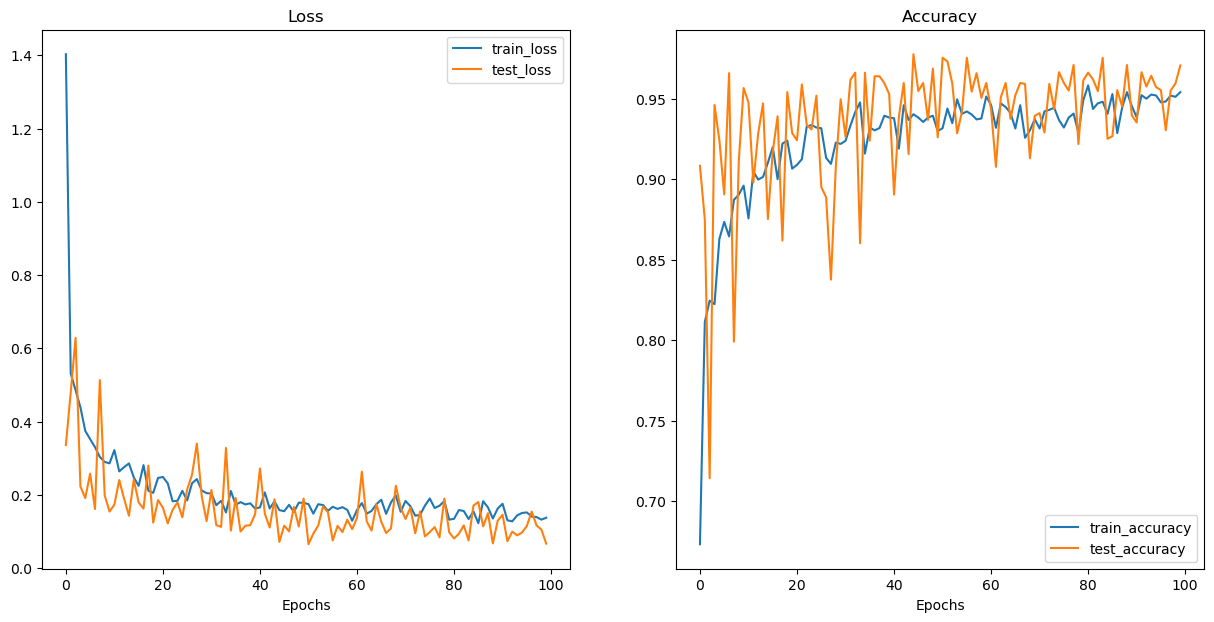

In [55]:
plot_loss_curves(cnn_model_results)

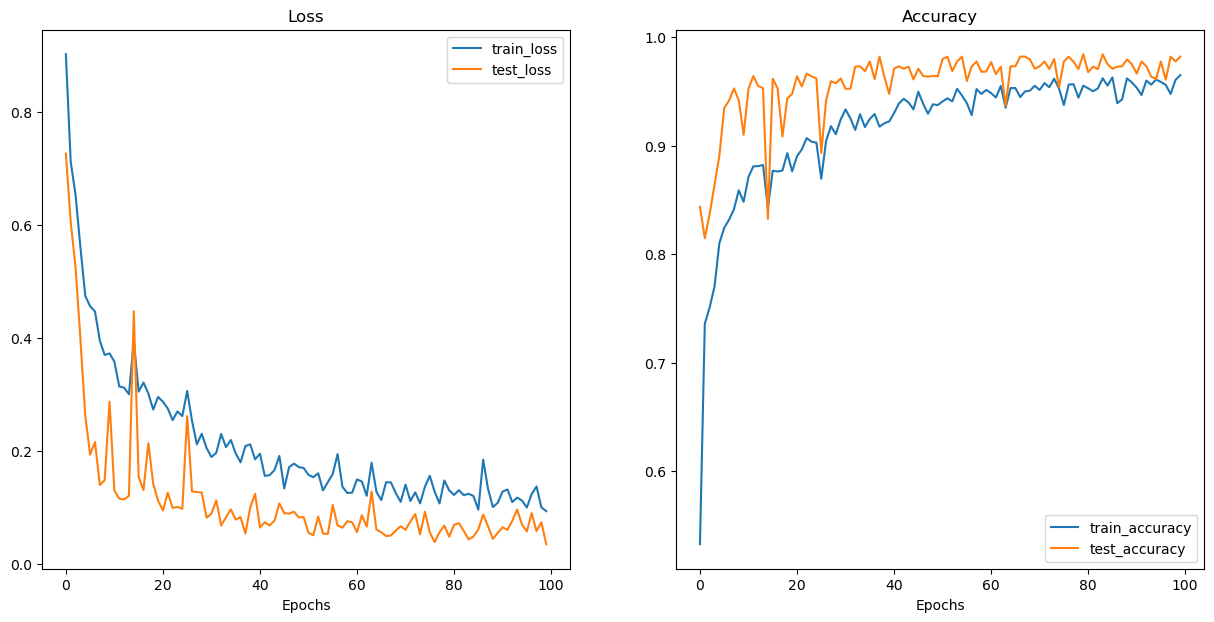

In [56]:
plot_loss_curves(model_TinyVGG_results)

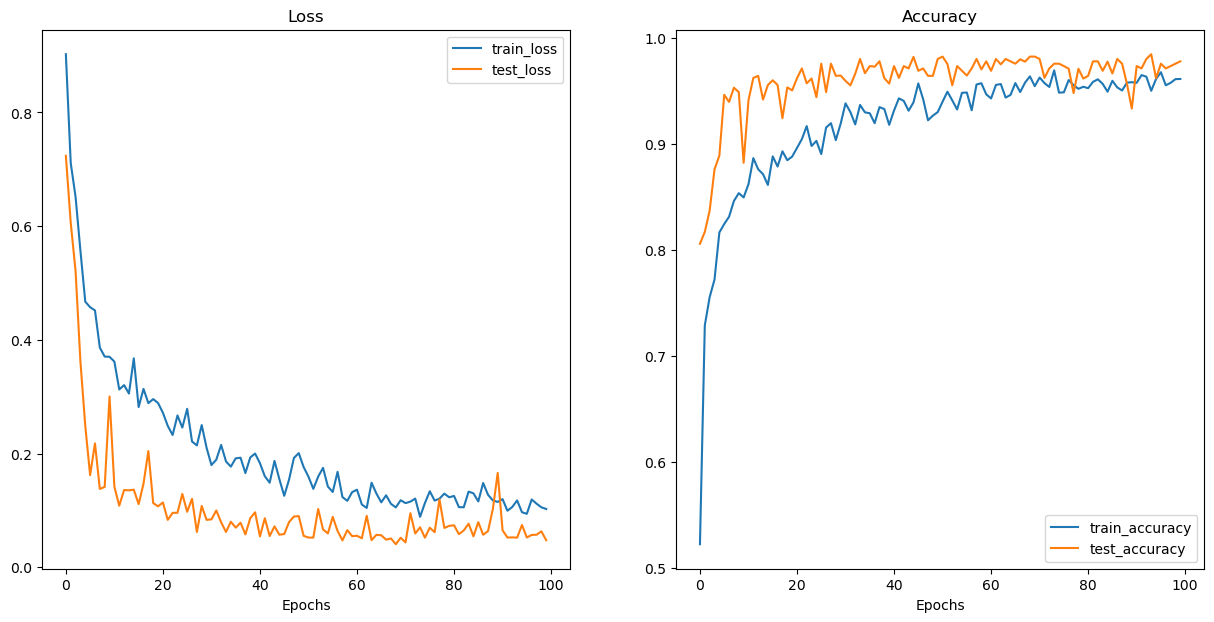

In [57]:
plot_loss_curves(model_0_results)

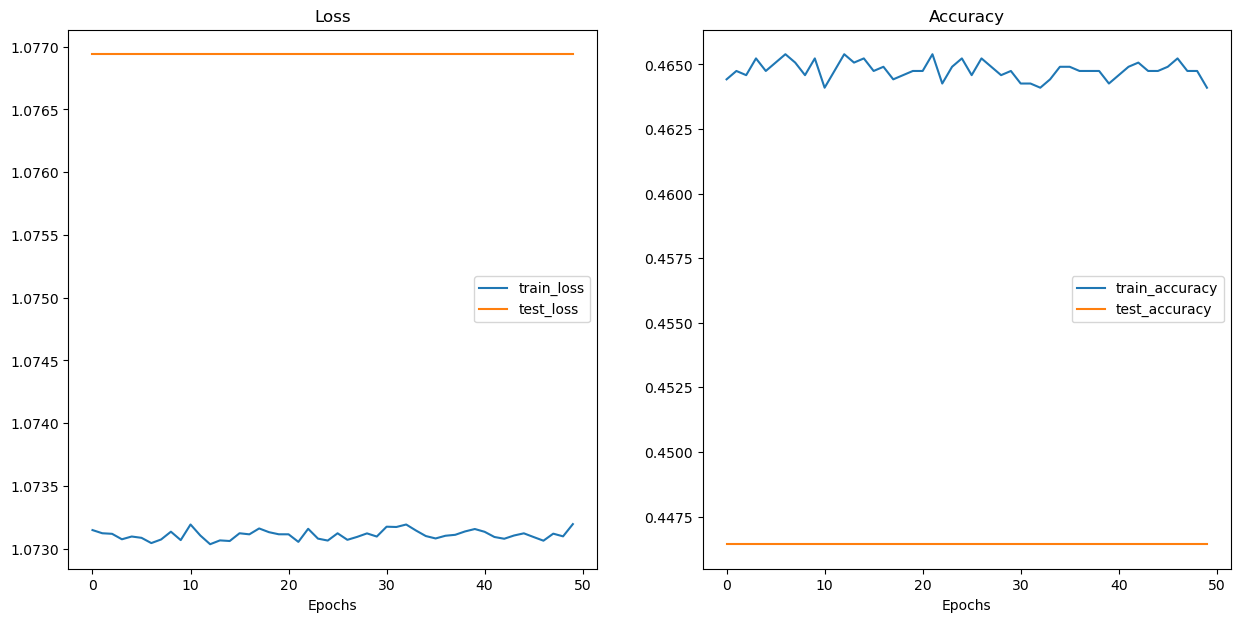

In [58]:
plot_loss_curves(model_1_results)

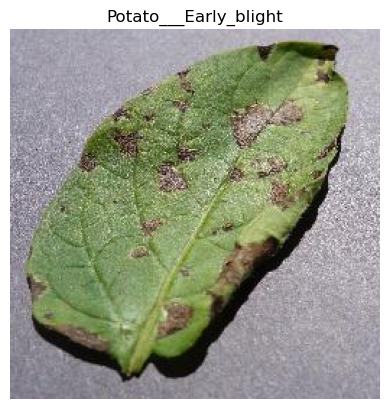

In [44]:
def get_random_image_and_label(val_loader, class_names):
    # Get the total number of samples in the validation dataset
    num_samples = len(val_loader.dataset)

    # Randomly choose an index
    random_index = random.randint(0, num_samples - 1)

    # Access the image and label using the randomly chosen index
    random_img, random_label = val_loader.dataset[random_index]

    # Display the randomly selected image
    plt.imshow(random_img.permute(1, 2, 0))
    title = class_names[random_label]
    plt.title(f"{title}")
    plt.axis(False)
    plt.show()

    return random_img, random_label

# Call the function
random_img, random_label = get_random_image_and_label(test_dataloader, class_names)

In [45]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
])

In [46]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

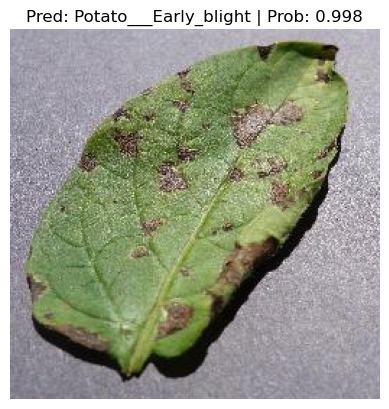

In [47]:
# Pred on our custom image
pred_and_plot_image(model=cnn_model,
                    image=random_img,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [48]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_potato_classifier_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=cnn_model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_potato_classifier_model_1.pth


In [49]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = CNN_model(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=3)

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
CNN_model(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=163840, out_features=3, bias=True)
  )
)
Model on device:
cuda:0


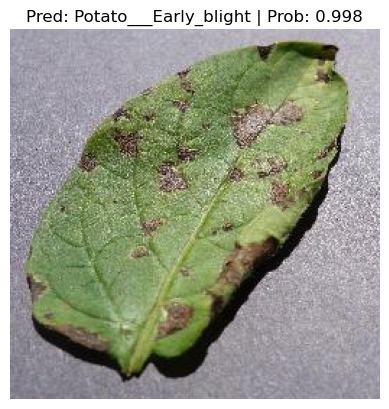

In [50]:
# Pred on our custom image
pred_and_plot_image(model=loaded_model_1,
                    image=random_img,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)